## CT5135 Research Topics in AI

## Assignment 2

* Student ID(s): 22229358, 22230186, 20230220
* Student name(s): KOSTADIN GEORGIEV, YAMINI GIRKAR, SHUBHAM MANGLAM

### **1. At first page, write your names, roll numbers, and group number, and then in 50-150 words, report who did what in the assignment e.g., who came up with the idea of how to implement it, who implemented it (as a whole or part of it), who debugged it, who gave suggestions (and what suggestion/s), who wrote the report, who did which simulations**

### **2. Explain how your group implemented the layer within existing library (keras, TensorFlow, PyTorch, or other) or from scratch.** [3 Marks]

#### Diagram of the proposed convolution operation

* H = height of input image
* W = width of input image
* C = number of channels of input

![Proposed Layer](img/proposed_layer.png)

### **3. Report the successful implementation of the layer and complete model with a figure in tensorboard.** [10 Marks]

### Imports

In [ ]:
import numpy as np
import pandas as pd
from collections import Counter
import os
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras import layers, models, activations, backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

%matplotlib inline

#### Constants and Random Seed

In [ ]:
SEED = 42
IMG_HEIGHT = 32
IMG_WIDTH = 32

tf.keras.utils.set_random_seed(SEED)

#### Implementation

In [434]:
class ProposedLayer(layers.Layer):
    def __init__(self, filters, rf=(3, 3), activation=None, **kwargs):
        super(ProposedLayer, self).__init__(**kwargs)
        self.filters = filters
        self.rf = rf
        self.activation = activations.get(activation)
    
    def build(self, input_shape):
        _, height, width, channels = input_shape
        w_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.1, seed=SEED)

        self.W = self.add_weight(name='kernel',
                                 shape=(height, width, channels, self.filters),
                                 initializer=w_initializer,
                                 trainable=True,
                                 dtype=tf.float32)
        self.B = self.add_weight(name='bias',
                                 shape=(self.filters,),
                                 initializer='ones',
                                 trainable=True,
                                 dtype=tf.float32)
        
        super(ProposedLayer, self).build(input_shape)

    def call(self, X):
        rfh = self.rf[0] # Height of receptive field
        rfw = self.rf[1] # Width of receptive field
        zh = X.shape[1] - self.rf[0] + 1 # Height of output
        zw = X.shape[2] - self.rf[1] + 1 # Width of output
        z = [] # Output

        # Apply the custom convolution filter wise
        for f in range(self.filters):
            w = self.W[:, :, :, f]
            b = self.B[f]
            conv = tf.multiply(X, w) + b

            # Collect patches (e.g., 3x3) from the convolved input.
            # All extracted patches are stacked in the last dimension of the output.
            patches = tf.image.extract_patches(
                images=conv,
                sizes=[1, rfh, rfw, 1],
                strides=[1, 1, 1, 1],
                rates=[1, 1, 1, 1],
                padding='VALID'
            )

            # The number of pixels in each patch would be rfh x rfw x channels (e.g., 3x3x3).
            # Convert the patches to a 2D tensor with shape (n_patches, rfh x rfw x channels)
            patches_2d = tf.reshape(patches, (-1, rfh * rfw * X.shape[3]))
            # Sum over the last axis to ignore 1st dimension which is batch size
            patch_sums = tf.math.reduce_sum(patches_2d, axis=-1)
            # Change the resulting shape back to fit the expected layer shape.
            patch_sums = tf.reshape(patch_sums, shape=(-1, zh, zw))

            z.append(patch_sums)
        
        z = tf.convert_to_tensor(z)
        z = tf.transpose(z, perm=[1, 2, 3, 0])
        a = self.activation(z) if self.activation is not None else z

        return a
    
    def compute_output_shape(self, input_shape):
        return tuple(input_shape[0],
                     input_shape[1] - self.rf[0] + 1,
                     input_shape[2] - self.rf[1] + 1,
                     self.filters)

### **4. Load and distribute the data for training, validation, and testing.** [2 Marks]

### Load Data

Provided images are of different heights so they should be resized to the same resolution. First, create a function which applies callback to each .jpg image in a directory:

In [143]:
def walk_directory(dir, callback, label=None):
    for dirname, _, filenames in os.walk(dir):
        for filename in filenames:
            if filename.endswith(".jpg"):
                id = filename[:-4]
                pathname = os.path.join(dirname, filename)
                im = Image.open(pathname)
                imnp = np.array(im, dtype=float)

                if len(imnp.shape) != 3:
                    print("This is 1 channel, so we omit it",
                          imnp.shape, filename)
                    continue

                callback(id, imnp, label)

Observe the dimensions of each image in the dataset:

In [438]:
df = pd.DataFrame(columns=['height', 'width', 'channels', 'label'])

def get_img_shape(id, imnp, label):
    height, width, channel = imnp.shape
    df.loc[id] = [height, width, channel, label]

walk_directory('dataset/alpaca', get_img_shape, 'alpaca')
walk_directory('dataset/not_alpaca', get_img_shape, 'not_alpaca')

df

This is 1 channel, so we omit it (683, 1024) 4b9ef3ce2685ee32.jpg
This is 1 channel, so we omit it (914, 1024) 5a71db307230880e.jpg


,height,width,channels,label
01ad3ff1d94eb557,670,1024,3,alpaca
0346463867a297f4,768,1024,3,alpaca
038fae9e70c4c3f1,768,1024,3,alpaca
053608552d63f724,768,1024,3,alpaca
053dab62fbb47736,682,1024,3,alpaca
...,...,...,...,...
eb4d2e0c0252fdc2,682,1024,3,not_alpaca
eb4f5968c7866a3e,699,1024,3,not_alpaca
f4495f8511553631,680,1024,3,not_alpaca
f8d3c3d8be68c4fd,768,1024,3,not_alpaca


#### Transform Data

In [442]:
def resize_images(label):
    source_dir = 'dataset/' + label
    target_dir = 'dataset_resized/'+ label
    subset = df.loc[df['label'] == label]

    for id, image in subset.iterrows():
        id = str(id)
        filename = id + ".jpg"
        
        source_path = os.path.join(source_dir, filename)
        target_path = os.path.join(target_dir, filename)
        
        image = Image.open(source_path)
        image = image.resize((IMG_WIDTH, IMG_HEIGHT), Image.NEAREST)
        image.save(target_path)

resize_images('alpaca')
resize_images('not_alpaca')
print('Images are resized to', IMG_HEIGHT, 'x', IMG_WIDTH)

Images are resized to 32 x 32


#### Load Data

In [443]:
def load_images(dir):
    img_array = []
    
    walk_directory(dir, lambda id, imnp, label: img_array.append(imnp))

    return np.array(img_array)

img_alpaca = load_images('dataset_resized/alpaca')
img_not_alpaca = load_images('dataset_resized/not_alpaca')

print('alpaca:', img_alpaca.shape)
print('not_alpaca:', img_not_alpaca.shape)

alpaca: (142, 32, 32, 3)
not_alpaca: (183, 32, 32, 3)


#### Pre-Process Data

Create arrays for all images and for all labels:

In [444]:
lbl_alpaca = np.ones(img_alpaca.shape[0], dtype=int)
lbl_not_alpaca = np.zeros(img_not_alpaca.shape[0], dtype=int)
labels = np.concatenate((lbl_alpaca, lbl_not_alpaca), axis=0)
img_array = np.concatenate((img_alpaca, img_not_alpaca), axis=0)

# Scale down data from 0-255 to 0-1
img_array = img_array / 255

print('img_array:', img_array.shape)
print('labels:', labels.shape)

img_array: (325, 32, 32, 3)
labels: (325,)


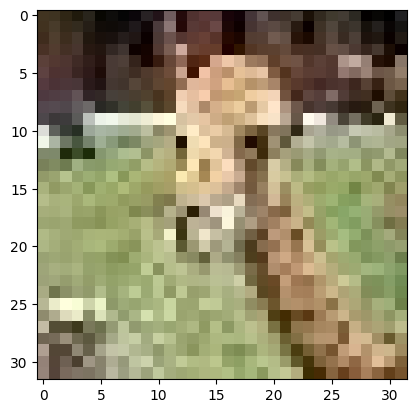

In [445]:
plt.imshow(img_array[1])

#### Create Train/Test Splits

Use 80% of the dataset as training data and 20% for testing.

In [360]:
(X_train, X_test,
 y_train, y_test) = train_test_split(img_array, labels, train_size = 0.8,
                                     random_state = SEED)

#### Oversample Minority Class

Use Synthetic Minority Oversampling Technique (SMOTE) to oversample the minority class which is 'alpaca'. It is important to apply this technique only to the training data and NOT to the test data.

In [361]:
oversample = SMOTE()
X_resampled = np.reshape(X_train, (X_train.shape[0], -1))
X_resampled, y_resampled = SMOTE().fit_resample(X_resampled, y_train)
X_resampled = np.reshape(X_resampled, (-1, X_train.shape[1], X_train.shape[2], X_train.shape[3]))

print(X_train.shape)
print(X_resampled.shape)

(260, 32, 32, 3)
(296, 32, 32, 3)


Create one-hot encodings for the labels:

In [362]:
y_resampled = to_categorical(y_resampled)
y_test = to_categorical(y_test)

### **5. Train the model with the dataset provided in this assignment folder and report the training and testing performance against various hyper parameters (e.g. learning rate = 0.1, batch size = 32, epochs = 500,) using stochastic gradient decent.** [5 Marks]

Define helper methods for dynamic creation of a model, plotting results and defining an F1-score metric:

In [446]:
def create_model(proposed_units=(16, 12, 8), dense_units=(16,)):
    # Input layer
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, 3), name="input")
    x = inputs

    # Proposed layer blocks with max pooling
    for i, units in enumerate(proposed_units):
        name1 = "proposed_" + str(i+1)
        name2 = "pooling_" + str(i+1)
        x = ProposedLayer(units, (3, 3), activation='relu', name=name1)(x)
        if i < len(proposed_units) - 1:
         x = layers.MaxPooling2D((2, 2), name=name2)(x)

    # Flatten feature map to produce embedding
    x = layers.Flatten(name="flatten")(x)

    # Fully-connected layers for classification
    for i, units in enumerate(dense_units):
        name = "dense_" + str(i+1)
        x = layers.Dense(units, activation='relu', name=name)(x)

    # Output layer with 2 units for the 2 classes
    outputs = layers.Dense(2, activation='softmax', name="output")(x)

    model = models.Model(inputs, outputs)

    return model

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def plot_history(history, epochs, step):
    plt.figure(1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['training loss', 'validation loss'], loc='upper right')
    plt.xlim(0, epochs-1)
    plt.xticks(np.arange(0, epochs, step))
    plt.grid(True)
    plt.rcParams['grid.color'] = (0.1, 0.1, 0.1, 0.1)
    for pos in ['right', 'top', 'bottom', 'left']:
        plt.gca().spines[pos].set_visible(False)
    plt.show()

#### Baseline network

In [450]:
proposed_units = (16, 12, 8)
dense_units = (64,)
optimizer = keras.optimizers.SGD(learning_rate=0.001)

base_model = create_model(proposed_units=proposed_units, dense_units=dense_units)
base_model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=[f1_m])
base_model.summary()

Model: "model_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 3)]       0         
                                                                 
 proposed_1 (ProposedLayer)  (None, 30, 30, 16)        49168     
                                                                 
 pooling_1 (MaxPooling2D)    (None, 15, 15, 16)        0         
                                                                 
 proposed_2 (ProposedLayer)  (None, 13, 13, 12)        43212     
                                                                 
 pooling_2 (MaxPooling2D)    (None, 6, 6, 12)          0         
                                                                 
 proposed_3 (ProposedLayer)  (None, 4, 4, 8)           3464      
                                                                 
 flatten (Flatten)           (None, 128)               0  

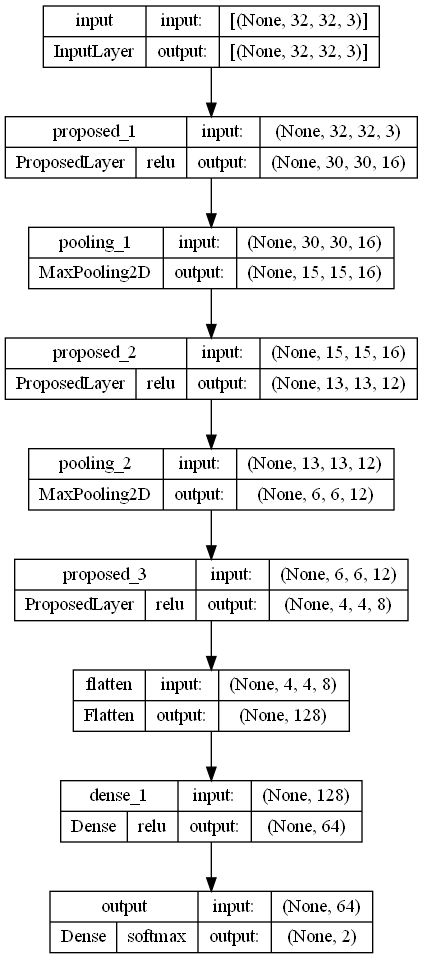

In [451]:
keras.utils.plot_model(base_model, show_shapes=True, rankdir="TB", show_layer_activations=True)

### **6. Report the analysis of the model against changes in network depth and width as well as changing hyper parameters i.e., show how performance increase or decrease by changing learning rate {0.01, 0.001, or other}, batch sizes {8, 16, 50, or others depending on your system/laptop capacity}, epochs {100, 200, 700, 1000 or other depending on the model performance}, optimizers e.g. Adam or other factors. Report all results in a table, even if they are not good. Also show their training and testing performance in the form of a graph.** [7 Marks]

This is the best config I have found so far, which results in F1-Score of 0.5588 on the test data:

In [470]:
proposed_units = (16, 12, 8)
dense_units = (64,)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.CategoricalCrossentropy()
batch_size = 4
epochs = 10

proposed_model = create_model(proposed_units=proposed_units, dense_units=dense_units)
proposed_model.compile(optimizer=optimizer, loss=loss, metrics=[f1_m])
proposed_history = proposed_model.fit(X_resampled, y_resampled, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
59/59 [==============================] - 10s 44ms/step - loss: 16.8641 - f1_m: 0.4746 - val_loss: 33.4320 - val_f1_m: 0.2333
Epoch 2/10
59/59 [==============================] - 2s 29ms/step - loss: 6.2664 - f1_m: 0.5000 - val_loss: 3.5816 - val_f1_m: 0.7667
Epoch 3/10
59/59 [==============================] - 2s 29ms/step - loss: 9.0954 - f1_m: 0.5000 - val_loss: 4.3958 - val_f1_m: 0.7667
Epoch 4/10
59/59 [==============================] - 2s 31ms/step - loss: 7.8506 - f1_m: 0.4576 - val_loss: 3.2994 - val_f1_m: 0.7667
Epoch 5/10
59/59 [==============================] - 2s 32ms/step - loss: 3.1037 - f1_m: 0.5339 - val_loss: 14.8616 - val_f1_m: 0.2333
Epoch 6/10
59/59 [==============================] - 2s 37ms/step - loss: 4.7187 - f1_m: 0.4831 - val_loss: 1.3604 - val_f1_m: 0.7667
Epoch 7/10
59/59 [==============================] - 3s 51ms/step - loss: 2.0791 - f1_m: 0.5042 - val_loss: 2.4638 - val_f1_m: 0.2333
Epoch 8/10
59/59 [==============================] - 2s 38ms/step 

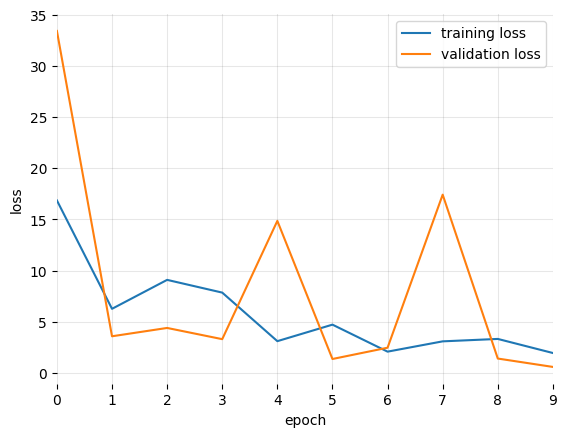

In [471]:
plot_history(proposed_history, epochs, 1)

In [472]:
result = proposed_model.evaluate(X_test, y_test, batch_size=batch_size)
print('Epochs:', epochs)
print('F1-Score:', str(round(result[1], 4)))

17/17 [==============================] - 1s 17ms/step - loss: 0.7045 - f1_m: 0.5588
Epochs: 10
F1-Score: 0.5588


### **7. Report what result you achieved after training a Convolutional Neural Network of same depth** [5 Marks]

In [453]:
def create_conv_model(conv_units=(16, 12, 8), dense_units=(16,)):
    # Input layer
    inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH, 3), name="input")
    x = inputs

    # Proposed layer blocks with max pooling
    for i, units in enumerate(conv_units):
        name1 = "conv_" + str(i+1)
        name2 = "pooling_" + str(i+1)
        x = layers.Conv2D(units, (3, 3), activation='relu', name=name1)(x)
        if i < len(conv_units) - 1:
         x = layers.MaxPooling2D((2, 2), name=name2)(x)

    # Flatten feature map to produce embedding
    x = layers.Flatten(name="flatten")(x)

    # Fully-connected layers for classification
    for i, units in enumerate(dense_units):
        name = "dense_" + str(i+1)
        x = layers.Dense(units, activation='relu', name=name)(x)

    # Output layer with 2 units for the 2 classes
    outputs = layers.Dense(2, activation='softmax', name="output")(x)

    model = models.Model(inputs, outputs)

    return model

In [473]:
conv_units = (16, 12, 8)
dense_units = (64,)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.CategoricalCrossentropy()
batch_size = 4
epochs = 10

conv_model = create_conv_model(conv_units=conv_units, dense_units=dense_units)
conv_model.compile(optimizer=optimizer, loss=loss, metrics=[f1_m])
conv_history = conv_model.fit(X_resampled, y_resampled, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/10
59/59 [==============================] - 1s 9ms/step - loss: 0.6900 - f1_m: 0.5720 - val_loss: 0.6928 - val_f1_m: 0.5333
Epoch 2/10
59/59 [==============================] - 0s 7ms/step - loss: 0.6837 - f1_m: 0.5636 - val_loss: 0.7305 - val_f1_m: 0.2333
Epoch 3/10
59/59 [==============================] - 0s 7ms/step - loss: 0.6715 - f1_m: 0.5720 - val_loss: 0.7125 - val_f1_m: 0.2833
Epoch 4/10
59/59 [==============================] - 0s 6ms/step - loss: 0.6593 - f1_m: 0.6441 - val_loss: 0.6264 - val_f1_m: 0.8000
Epoch 5/10
59/59 [==============================] - 0s 6ms/step - loss: 0.6210 - f1_m: 0.6822 - val_loss: 0.6242 - val_f1_m: 0.7500
Epoch 6/10
59/59 [==============================] - 0s 6ms/step - loss: 0.5969 - f1_m: 0.6610 - val_loss: 0.6052 - val_f1_m: 0.6833
Epoch 7/10
59/59 [==============================] - 0s 6ms/step - loss: 0.5411 - f1_m: 0.7203 - val_loss: 0.5963 - val_f1_m: 0.8167
Epoch 8/10
59/59 [==============================] - 0s 6ms/step - loss: 0.52

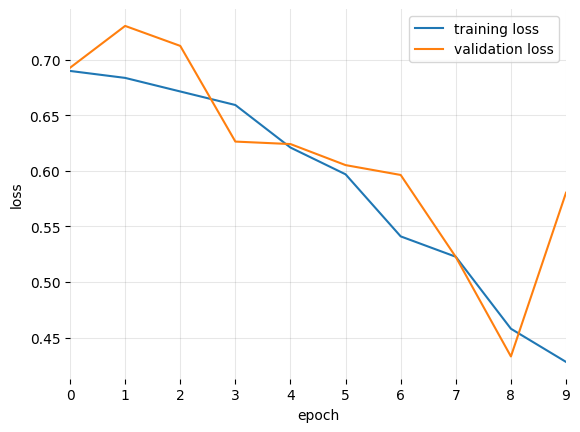

In [474]:
plot_history(conv_history, epochs, 1)

In [475]:
result = conv_model.evaluate(X_test, y_test, batch_size=batch_size)
print('Epochs:', epochs)
print('F1-Score:', str(round(result[1], 4)))

17/17 [==============================] - 0s 3ms/step - loss: 0.8754 - f1_m: 0.6029
Epochs: 10
F1-Score: 0.6029


conv_units = (16, 12, 8)
dense_units = (64,)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss = keras.losses.CategoricalCrossentropy()
batch_size = 4
epochs = 10
| Model | Conv Units | Dense Units | Optimiser | Learning Rate | Batch Size | Epochs | F1-Score |
|-------|------------|-------------|-----------|---------------|------------|--------|----------|
| Proposed | (16, 12, 8) | (64,) | Adam | 0.001 | 4 | 10 |  **0.5588** |
| Conv2D   | (16, 12, 8) | (64,) | Adam | 0.001 | 4 | 10 |  **0.6029** |

**TODO** Discuss results

### **8. How to change the code to work over 1-Dimensional data?** [2 Marks]

Our implementation is dynamic so it allows data with any number of channels including 1D data.

### **9. How to change the code to work over 3-Dimensional data?** [2 Marks]

Our implementation is dynamic so it allows data with any number of channels including 3D data.